In [133]:
from dotenv import load_dotenv
load_dotenv()

True

In [134]:
# from langchain_ollama import ChatOllama

# llm = ChatOllama(model="llama3.2")
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.2-90b-vision-preview")

In [135]:
# Tools
import random

from langchain_core.messages import SystemMessage, HumanMessage

def createAnagram(a: str, b: str) -> str:
  """This functiton creates an anangram using the the words wrapped around in single quotets. 

  Args:
      a: First word wrapped around in single quotes; exclude the single quotes when passing in
      b: Second word wrapped around in single quotes; exclude the single quotes when passing in
  """
  list_chars = list(a + b)
  random.shuffle(list_chars)
  return ''.join(list_chars)

def boxTheWord(a: str) -> str:
  """This function will add '|' at the beginning and the end of the word

  Args:
      a: Word  that is wrapped around in single quotes; exclude the single quotes when passing in

  """
  
  return "|" + a + "|"

def generateExplanation(korean_message: str) -> str:
  """This function is going to translate the Korean message into English

  Args:
      korean_message: Korean message
  """
  
  sys_msg = """
  You are a Korean-English translator. Translate Korean message into English as accurately as possible. 
  Also, you are a cute translator. Add cute and sweet sentiment when traslating Korean message into English.
  """
  
  response = llm.invoke([SystemMessage(content=sys_msg), HumanMessage(content=korean_message)] )
  return response.content


tools = [createAnagram, boxTheWord, generateExplanation]

llm_with_tools = llm.bind_tools(tools)

In [136]:
# State
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, RemoveMessage
from langgraph.graph import add_messages

class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]
  summary: str
  

In [137]:
# Node

def tool_calling_llm(state):
  sys_msg = ("You are a helpful assistant that helps with the user requests.\n")
  
  if state.get('summary'):
    sys_msg += ("Use the following summary of the earlier conversation for the context.\n"
                f"Summary of the earlier conversation: {state['summary']}")
  return {
    "messages": llm_with_tools.invoke([SystemMessage(content=sys_msg)] + state['messages'])
  }
  
def summarizing_llm(state):
  if state.get('summary'):
    request = f"""
    Summary of the earlier conversation: {state['summary']}
    
    Summarize the new conversations of above and extend the summary.
    """
  else:
    request = """Summarize the above conversation"""
    
  response = llm.invoke(state['messages'] + [HumanMessage(content=request)])
  
  return {
    'messages': [RemoveMessage(id=m.id) for m in state['messages'][:-2]],
    'summary': response.content
  }
    

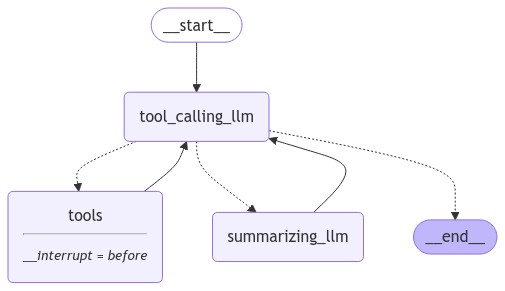

In [138]:
# builder
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode

builder = StateGraph(State)
builder.add_node(tool_calling_llm)
builder.add_node(ToolNode(tools))
builder.add_node(summarizing_llm)

# edge
def summarize_and_react_conditional(state):
  if len(state['messages']) > 6:
    return "summarizing_llm"
  else:
    return _react_tool_condititonal(state)
  
def _react_tool_condititonal(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', summarize_and_react_conditional)
builder.add_edge('tools', 'tool_calling_llm')
builder.add_edge('summarizing_llm', 'tool_calling_llm')

from sqlite3 import connect
db_path = 'db/breakpoint.db'
conn = connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)
graph = builder.compile(memory, interrupt_before=['tools'])

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [139]:
config = {'configurable': {'thread_id': 1}}

input = "hmm now translate this: 나는 천재입니다. 하지만 이건 너무 어렵네요"
state = {
  "messages": [HumanMessage(input)]
}

stream = graph.stream(state, config, stream_mode='updates')

In [140]:
for m in stream: 
  print(m.values)
  print('---' * 25)

<built-in method values of AddableUpdatesDict object at 0x000001C2E29A9910>
---------------------------------------------------------------------------
<built-in method values of AddableUpdatesDict object at 0x000001C2E2A600B0>
---------------------------------------------------------------------------
<built-in method values of AddableUpdatesDict object at 0x000001C2E29A9910>
---------------------------------------------------------------------------


In [141]:

snapshot = graph.get_state(config)
print(dir(snapshot))


for m in snapshot.values['messages']:
  m.pretty_print()
  
snapshot.metadata


['__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__orig_bases__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'config', 'count', 'created_at', 'index', 'metadata', 'next', 'parent_config', 'tasks', 'values']
================================ Human Message =================================

hmm now translate this: 나는 천재입니다. 하지만 이건 너무 어렵네요
================================== Ai Message ==================================
Tool Calls:
  generateExplanation (call_x8qw)
 Call ID: call_x8qw
  Args:
    korean_message: 나 천집입

{'source': 'loop',
 'writes': {'tool_calling_llm': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 832, 'total_tokens': 833, 'completion_time': 0.007635792, 'prompt_time': 0.097340863, 'queue_time': -9223372036.952118, 'total_time': 0.104976655}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_9c2a937c92', 'finish_reason': 'stop', 'logprobs': None}, id='run-508a1b64-dc29-4955-b3cc-a7274d7fa010-0', usage_metadata={'input_tokens': 832, 'output_tokens': 1, 'total_tokens': 833})}},
 'step': 45,
 'parents': {}}

In [142]:
# snapshot_history = graph.get_state_history(config)

# for snapshot in snapshot_history:
#   print(snapshot.metadata)
#   print('---' * 25)

In [143]:
new_stream = graph.stream(None, config)
new_stream

<generator object Pregel.stream at 0x000001C2E283D9A0>

In [144]:
for info in new_stream:
  print(info)
  print('---' * 25)